In [2]:
%pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

Note: you may need to restart the kernel to use updated packages.


In [3]:
from base64 import b64encode

import os
import numpy
from pathlib import Path
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import torchvision.transforms as T
import torch.nn.functional as F

torch.manual_seed(1)
logging.set_verbosity_error()
torch_device = "cpu"

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

token_emb_layer = text_encoder.text_model.embeddings.token_embedding
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)


In [4]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images
	
	
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output	


In [5]:
#  Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925


In [6]:
def load_embedding(path):
    return  torch.load(path)
	

def sobel_operator(img):
    channels = img.shape[1]

    # Define the Sobel kernels
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    sobel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Replicate the Sobel kernels for each channel
    sobel_x = sobel_x.repeat(channels, 1, 1, 1).to(img.device)
    sobel_y = sobel_y.repeat(channels, 1, 1, 1).to(img.device)

    # Convolve the image with the Sobel kernels
    grad_x = F.conv2d(img, sobel_x, padding=1, groups=channels)
    grad_y = F.conv2d(img, sobel_y, padding=1, groups=channels)

    # Combine the x and y gradients
    magnitude = torch.sqrt(grad_x**2 + grad_y**2)

    return magnitude


def edge_loss(img):
    edge_detected = sobel_operator(img)
    thresholded = (edge_detected > 0.5).float()  # You can adjust the threshold as needed
    return F.mse_loss(edge_detected, thresholded)

In [7]:
def generate_loss_based_image(text_embeddings, seed, max_length):

    height = 64               
    width = 64                    
    num_inference_steps = 10       
    guidance_scale = 8 
    seed = 64            
    generator = torch.manual_seed(seed)  
    batch_size = 1
    edge_loss_scale = 200
    step = ""

    try:
        step = " uncond_input "
        uncond_input = tokenizer(
            [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )

        step = " uncond embed nograd "
        with torch.no_grad():
            uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # Prep Scheduler
        step = " set tsteps "
        set_timesteps(scheduler, num_inference_steps+1)

        # Prep latents
        step = " latents randn "
        latents = torch.randn(
        (batch_size, unet.in_channels, height // 8, width // 8),
        generator=generator,
        )
        latents = latents.to(torch_device)
        latents = latents * scheduler.init_noise_sigma

        # sched_out = None

        # Loop
        for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            step = " latent_model_input "
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            step = " noise_pred "
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform CFG
            step = " noise_pred_uncond "
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            ### ADDITIONAL GUIDANCE ###
            if i%5 == 0 and i>0:
                # Requires grad on the latents
                latents = latents.detach().requires_grad_()

                # Get the predicted x0:
                scheduler._step_index -= 1
                latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

                # Decode to image space
                denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)


                # Calculate egde loss
                step = " edge loss "
                loss = edge_loss(denoised_images) * edge_loss_scale

                # Occasionally print it out
                if i%10==0:
                    print(i, 'loss:', loss)

                # Get gradient
                cond_grad = torch.autograd.grad(loss, latents)[0]

                # Modify the latents based on this gradient
                latents = latents.detach() - cond_grad * sigma**2
                # To PIL Images
                im_t0 = latents_to_pil(latents_x0)[0]
                im_next = latents_to_pil(latents)[0]

            # Now step with scheduler
            latents = scheduler.step(noise_pred, t, latents).prev_sample
    except Exception as ex:
        print(f"Error generating loss image at step: {step}, {ex}")    
    return latents_to_pil(latents)[0]

In [8]:
#Generating an image with these modified embeddings
def generate_with_embs(text_embeddings, seed, max_length):
    # height = 512                        # default height of Stable Diffusion
    # width = 512                         # default width of Stable Diffusion
    # num_inference_steps = 30            # Number of denoising steps
    # guidance_scale = 7.5                # Scale for classifier-free guidance
    # generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    # batch_size = 1

    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1
    step = ""

    try:
        # tokenizer
        step = " tokenizer "
        uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )
        
        step = " no_grad "
        with torch.no_grad():
            uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # Prep Scheduler
        set_timesteps(scheduler, num_inference_steps)

        # Prep latents
        step = " prep_latents "
        latents = torch.randn(
        (batch_size, unet.in_channels, height // 8, width // 8),
        generator=generator,
        )
        latents = latents.to(torch_device)
        latents = latents * scheduler.init_noise_sigma

        # Loop
        for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            step = f" latent {i} "
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            tep = f" latents {i} "
            latents = scheduler.step(noise_pred, t, latents).prev_sample
    except Exception as ex:
        print(f"Error generating loss image at step: {step}, {ex}")  
    return latents_to_pil(latents)[0]


def generate_image_from_embeddings(mod_output_embeddings, seed, max_length):
    seed = 32
    generator = torch.manual_seed(seed)   # (32)
    height=512
    width=512
    num_inference_steps=50
    guidance_scale=8
    batch_size = 1
    edge_loss_scale = 200
    step = ""

    # Make a folder to store results
    # !rm -rf steps/    # Commenting out these for now. Use os module for directory operations.
    # !mkdir -p steps/

    # Use the modified_output_embeddings directly
    text_embeddings = mod_output_embeddings # modified_output_embeddings
    # max_length = tokenizer.model_max_length

    try:
        uncond_input = tokenizer(
            [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )
        with torch.no_grad():
            uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # Prep Scheduler
        set_timesteps(scheduler, num_inference_steps)

        # Prep latents
        step = " randn "
        latents = torch.randn(
        (batch_size, unet.config.in_channels, height // 8, width // 8),
        generator=generator,
        )
        latents = latents.to(torch_device)
        latents = latents * scheduler.init_noise_sigma

        # Loop
        for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            step = " scale "
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform CFG
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            #### ADDITIONAL GUIDANCE ###
            step = " latents "
            if i%5 == 0:
                # Requires grad on the latents
                latents = latents.detach().requires_grad_()

                # Get the predicted x0:
                step = " step_index "
                scheduler._step_index -= 1
                latents_x0 = latents - sigma * noise_pred
                #latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

                # Decode to image space
                step = " denoised "
                denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

                # Calculate loss
                step = " edge loss "
                loss = edge_loss(denoised_images) * edge_loss_scale

                # Occasionally print it out
                if i%10==0:
                    print(i, 'loss:', loss.item())

                # Get gradient
                step = " cond_grad "
                cond_grad = torch.autograd.grad(loss, latents)[0]

                # Modify the latents based on this gradient
                latents = latents.detach() - cond_grad * sigma**2

            # Now step with scheduler
            step = " sch latents "
            latents = scheduler.step(noise_pred, t, latents).prev_sample
    except Exception as ex:
        print(f"Error generating image from embeddings step: {step}, {ex}")  

    return latents_to_pil(latents)[0]


def generate_image_from_embeddings_prev(text_embeddings, seed, max_length):
    # generator = torch.manual_seed(seed)
    batch_size = 1
    edge_loss_scale = 200

    # height = 64               
    # width = 64    
    height = 512               
    width = 512   
    seed = 32
    generator = torch.manual_seed(seed)               
    num_inference_steps = 50      
    guidance_scale = 8             
    generator = torch.manual_seed(64)  
    batch_size = 1
    latents = None
    noise_pred = None

    try:
        step = " uncond inp "
        uncond_input = tokenizer(
            [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )

        step = " uncond emb "
        with torch.no_grad():
            uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # Prep Scheduler
        set_timesteps(scheduler, num_inference_steps)

        # Prep latents
        step = " latents "
        latents = torch.randn(
        (batch_size, unet.config.in_channels, height // 8, width // 8),
        generator=generator,
        )
        latents = latents.to(torch_device)
        latents = latents * scheduler.init_noise_sigma

        # Loop
        for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
            step = f" loop {i} "
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            step = " noise_pred "
            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform CFG
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            #### ADDITIONAL GUIDANCE ###
            step = " latents bef i%5 "
            if i%5 == 0:
                # Requires grad on the latents
                latents = latents.detach().requires_grad_()

                # Get the predicted x0:
                scheduler._step_index -= 1
                latents_x0 = latents - sigma * noise_pred
                #latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

                # Decode to image space
                denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

                step = " edge loss "
                # Calculate loss
                loss = edge_loss(denoised_images) * edge_loss_scale

                # Occasionally print it out
                if i%10==0:
                    print(i, 'loss:', loss.item())

                # Get gradient
                step = " cond_grad "
                cond_grad = torch.autograd.grad(loss, latents)[0]

                # Modify the latents based on this gradient
                step = " aft cond_grad "
                latents = latents.detach() - cond_grad * sigma**2

            # Now step with scheduler
            step = " latents - step "
            latents = scheduler.step(noise_pred, t, latents).prev_sample
    except Exception as ex:
        print(f"Error generating loss image at step: {step}, {ex}")

    return latents_to_pil(latents)[0]


def generate_style_image(prompt, style_embed, style_seed, style_embedding_key):
    modified_output_embeddings = None
    gen_out_style_image = None
    max_length = 0
    step = ""

    try:
        step = " input_ids "
        # Tokenize
        text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
        input_ids = text_input.input_ids.to(torch_device)

        # Get token embeddings
        token_embeddings = token_emb_layer(input_ids)
        
        # replacement_token_embedding = style_embed.to(torch_device)
        step = " style_embed "
        replacement_token_embedding = style_embed[style_embedding_key]
        # Insert this into the token embeddings
        step = " insert embed into "
        # print(f"replacement_token_embedding: {replacement_token_embedding}")
        
        # Insert this into the token embeddings
        token_embeddings[0, torch.where(input_ids[0] == 6829)[0]] = replacement_token_embedding.to(torch_device)

        # Combine with pos embs
        step = " embed add "
        input_embeddings = token_embeddings + position_embeddings

        #  Feed through to get final output embs
        step = " modified op embeds "
        modified_output_embeddings = get_output_embeds(input_embeddings)

        # And generate an image with this:
        step = " max-length "
        max_length = text_input.input_ids.shape[-1]

        step = " gen style output "
        gen_out_style_image = generate_with_embs(modified_output_embeddings, style_seed, max_length)
    except Exception as ex:
        print(f"Error occurred generating style image,  at step: {step}, {ex}")
    return gen_out_style_image


def generate_loss_image(prompt, style_embed, style_seed, style_embedding_key):
    step = ""
    gen_out_loss_image = None

    try:
        step = " tokenizer "
        # Tokenize
        text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
        input_ids = text_input.input_ids.to(torch_device)

        # Get token embeddings
        token_embeddings = token_emb_layer(input_ids)
        step = " style_embed "        
        replacement_token_embedding = style_embed[style_embedding_key].to(torch_device)

        # Insert this into the token embeddings
        step = " replace "
        token_embeddings[0, torch.where(input_ids[0] == 6829)[0]] = replacement_token_embedding

        # Combine with pos embs
        step = " output embeds "
        input_embeddings = token_embeddings + position_embeddings
        modified_output_embeddings = get_output_embeds(input_embeddings)

        # generate loss image
        step = " loss image "
        max_length = tokenizer.model_max_length
        gen_out_loss_image = generate_image_from_embeddings(modified_output_embeddings, style_seed, max_length)
    except Exception as ex:
        print(f"Error occurred while generating loss image at step:{step}, {ex}")
    return gen_out_loss_image


In [9]:
# Style embeddings
STYLE_EMBEDDINGS = {
    "illustration-style": "illustration_style.bin",
    "freefonix-style": "Freefonix.bin",
    "sculptural-style": "diaosu.bin",
    "herge-style": "herge.bin",
    "summie-style": "summie_style.bin",
    "birb-style": "birb_style.bin"
}

In [10]:
def generate_image_from_prompt_and_style(text_in, style_in):
    gen_style_image = None
    gen_loss_image = None
    step = ""
    STYLE_KEYS = []
    style_key = ""

    try:
        step = " input style "
        if style_in not in STYLE_EMBEDDINGS:
            raise ValueError(f"Unknown style: {style_in}. Available styles are: {', '.join(STYLE_EMBEDDINGS.keys())}")

        step = " input "
        # Set up Seeds, Style_keys etc.,
        STYLE_SEEDS = [32, 64, 128, 16, 8, 96]
        STYLE_KEYS = list(STYLE_EMBEDDINGS.keys())
        print(f"prompt: {text_in}")
        print(f"style: {style_in}")
    
        idx = STYLE_KEYS.index(style_in)
        style_file = STYLE_EMBEDDINGS[style_in]
        print(f"style_file: {style_file}")
        
        prompt = text_in 

        step = " torch load "
        style_seed = STYLE_SEEDS[idx]
        # style_dict = torch.load(style_file)
        # style_dict = load_embedding(style_file)

        step = " style params "
        style_key = Path(style_file).stem
        style_key = style_key.replace("_", "-")
        
        step = " load "
        file_path = os.path.join(os.getcwd(), style_file)
        embedding = load_embedding(file_path)
        # print(f"embedding: {embedding}")
        style_key = f"<{style_key}>"        
        print(f"style_key: {style_key}")

        step = " gen style image "
        gen_style_image = generate_style_image(prompt, embedding, style_seed, style_key)

        step = " gen loss image "
        gen_loss_image = (generate_loss_image(prompt, embedding, style_seed, style_key))
    except Exception as ex:
        print(f"Error occurred at step: {step}, {ex}")
    return [gen_style_image, gen_loss_image]

In [11]:
input_p = "A mouse in the style of illustration"
# input_s = "freefonix-style"
# input_s = "illustration-style"
input_s = "sculptural-style"
s_img, l_img = generate_image_from_prompt_and_style(input_p, input_s)

prompt: A mouse in the style of illustration
style: sculptural-style
style_file: diaosu.bin
style_key: <diaosu>


C:\Users\Pankaja\AppData\Local\Temp\ipykernel_15676\3425114286.py:36: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 3.4105312824249268
10 loss: 18.22002410888672
20 loss: 4.176222324371338
30 loss: 3.496511697769165
40 loss: 3.477808952331543


**Display the above outputs**

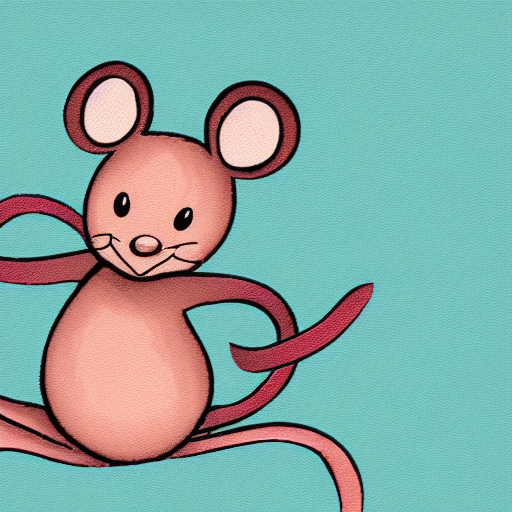

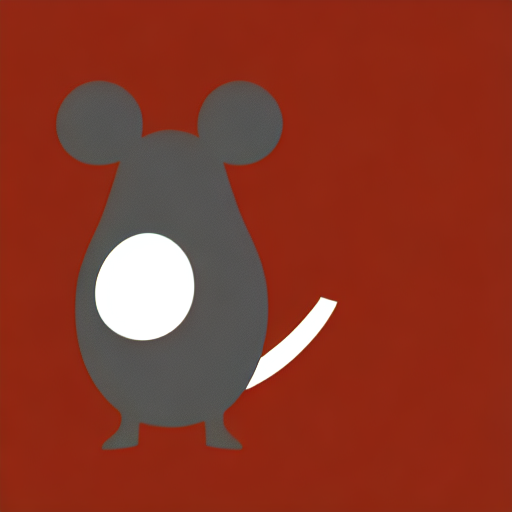

In [12]:
display(s_img)
display(l_img)